# Loading Required Packages

In [2]:
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sklearn
import sys
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,StandardScaler
import warnings


from sklearn.metrics import mean_squared_error
import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score,RandomizedSearchCV


warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 100)

In [21]:
def print_version(module, module_name):
    try:
        version = module.__version__
    except AttributeError:
        version = "No version attribute"
    print(f"{module_name} version: {version}")

for module,name in [(pd, 'pandas')
,(np, 'numpy')
,(matplotlib, 'matplotlib')
,(sklearn, 'sklearn')
,(sns, 'seaborn')
,(xgboost, 'xgboost')]:
    print_version(module,name)

'''
pandas version: 2.2.2
numpy version: 1.24.3
matplotlib version: 3.8.4
sklearn version: 1.4.2
seaborn version: 0.13.2
xgboost version: 2.0.3
'''

pandas version: 2.2.2
numpy version: 1.24.3
matplotlib version: 3.8.4
sklearn version: 1.4.2
seaborn version: 0.13.2
xgboost version: 2.0.3


# Loading Data

#### Remote repository Url

In [2]:
Sales_Data_url='https://drive.google.com/uc?id=1b9T0ZLpoITsb1A4u69-ykl6T5Skct4ER'
Store_Data_url ='https://drive.google.com/uc?id=1EaEpVwZdl3K-AzQljWQFfyUaazxV7l2Z'

#### Loading data from remote repository in csv format

In [3]:
Sales_Data = pd.read_csv(Sales_Data_url)
Store_Data = pd.read_csv(Store_Data_url)

In [16]:
# from google.colab import drive
# drive.mount('/content/drive') #/MyDrive/PlacementProject/

In [17]:
Sales_Data

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,31-07-2015,5263,555,1,1,0,1
1,2,5,31-07-2015,6064,625,1,1,0,1
2,3,5,31-07-2015,8314,821,1,1,0,1
3,4,5,31-07-2015,13995,1498,1,1,0,1
4,5,5,31-07-2015,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,01-01-2013,0,0,0,0,a,1
1017205,1112,2,01-01-2013,0,0,0,0,a,1
1017206,1113,2,01-01-2013,0,0,0,0,a,1
1017207,1114,2,01-01-2013,0,0,0,0,a,1


In [18]:
Store_Data

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


# Evaluation Metrics

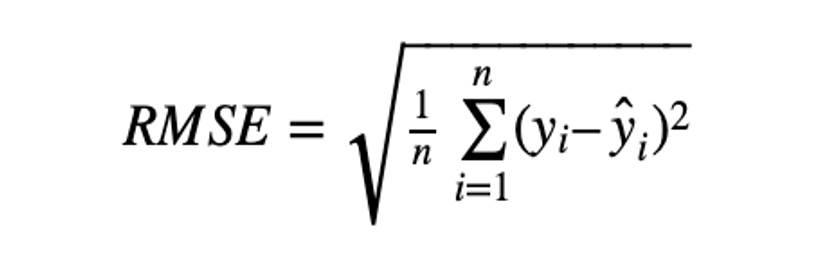

In [4]:
def root_mean_square_error(y_true,y_pred):
    return pow(mean_squared_error(y_true,y_pred),1/2)

## Inner Joining both dataframes on common column `Store`

In [5]:
Merged_Sales_Data = pd.merge(Sales_Data,Store_Data,on='Store',how='inner')

In [6]:
Merged_Sales_Data

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,31-07-2015,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,31-07-2015,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,31-07-2015,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,31-07-2015,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,31-07-2015,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,01-01-2013,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1017205,1112,2,01-01-2013,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1017206,1113,2,01-01-2013,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,01-01-2013,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


### Releaseing memory 

In [7]:
del(Sales_Data)
del(Store_Data)

In [24]:
# pd.set_option('display.max_rows',100)
Merged_Sales_Data


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,31-07-2015,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,31-07-2015,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,31-07-2015,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,31-07-2015,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,31-07-2015,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,01-01-2013,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1017205,1112,2,01-01-2013,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1017206,1113,2,01-01-2013,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,01-01-2013,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [27]:
Merged_Sales_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 22 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  object        
 8   SchoolHoliday              1017209 non-null  int64         
 9   StoreType                  1017209 non-null  object        
 10  Assortment                 1017209 non-null  object        
 11  CompetitionDistance        1014567 no

# Date

In [8]:
Merged_Sales_Data['Date'] = pd.to_datetime(Merged_Sales_Data['Date'],format='%d-%m-%Y')
Merged_Sales_Data['Year'] = Merged_Sales_Data['Date'].dt.year
Merged_Sales_Data['Month'] = Merged_Sales_Data['Date'].dt.month
Merged_Sales_Data['Day'] = Merged_Sales_Data['Date'].dt.day
Merged_Sales_Data['WeekOfYear'] = Merged_Sales_Data['Date'].dt.isocalendar()['week']

In [28]:
# Merged_Sales_Data.sort_values(by='Date',inplace=True,ignore_index=True)

In [9]:
Merged_Sales_Data

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",2013,1,1,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN,2013,1,1,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1


# Spliting Train and Test set

In [10]:
Train = Merged_Sales_Data[Merged_Sales_Data['Year'] != 2015].copy()
Test = Merged_Sales_Data[Merged_Sales_Data['Year'] == 2015].copy()

Training Set: 76.76% of the total Train
Test Set: 23.24% of the total Train


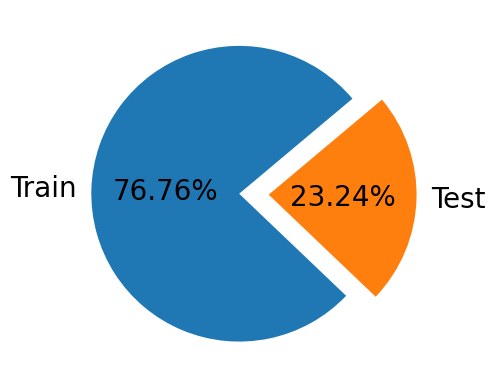

In [11]:
Train_percentage = (Train.shape[0] * 100) / Merged_Sales_Data.shape[0]
test_percentage = (Test.shape[0] * 100) / Merged_Sales_Data.shape[0]
plt.pie([Train_percentage,test_percentage],labels=['Train','Test'],autopct='%.2f%%',explode=[.1,.1],textprops=dict(size=20,color='black'),pctdistance=.5,startangle=40)
print(f"Training Set: {Train_percentage:.2f}% of the total Train")
print(f"Test Set: {test_percentage:.2f}% of the total Train")


In [32]:
Train.shape, Test.shape

((780829, 22), (236380, 22))

In [33]:
del(Merged_Sales_Data)

In [34]:
Train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
236380,1,3,2014-12-31,2605,327,1,0,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2014,12,31,1
236381,2,3,2014-12-31,2269,252,1,0,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2014,12,31,1
236382,3,3,2014-12-31,3804,408,1,0,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2014,12,31,1
236383,4,3,2014-12-31,10152,1311,1,0,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,2014,12,31,1
236384,5,3,2014-12-31,1830,217,1,0,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,2014,12,31,1


In [35]:
Train.isna().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2006
CompetitionOpenSinceMonth    248300
CompetitionOpenSinceYear     248300
Promo2                            0
Promo2SinceWeek              392703
Promo2SinceYear              392703
PromoInterval                392703
Year                              0
Month                             0
Day                               0
WeekOfYear                        0
dtype: int64

In [36]:
Train['Date'].describe()

count                           780829
mean     2013-12-19 22:05:54.868991744
min                2013-01-01 00:00:00
25%                2013-06-25 00:00:00
50%                2013-12-17 00:00:00
75%                2014-06-10 00:00:00
max                2014-12-31 00:00:00
Name: Date, dtype: object

# Sales

<Axes: xlabel='Sales', ylabel='Count'>

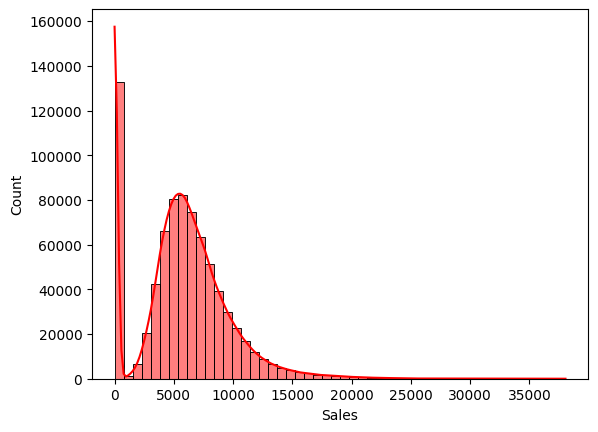

In [12]:
sns.histplot(
    Train['Sales'],
    color='red',
    kde=True,
    bins=50)

In [15]:
Train['Open'].value_counts()

Open
1    648360
0    132469
Name: count, dtype: int64

**Inferences** 
- Sales seems LogNoramally distributed with Alot of zero values.
- Why Zeros?: Many entries are recorded with zero sales, Even when Store is Closed, Also Holidays & Refurbishment might be another reason


# StoreType, Sales and Status(open=1/0)

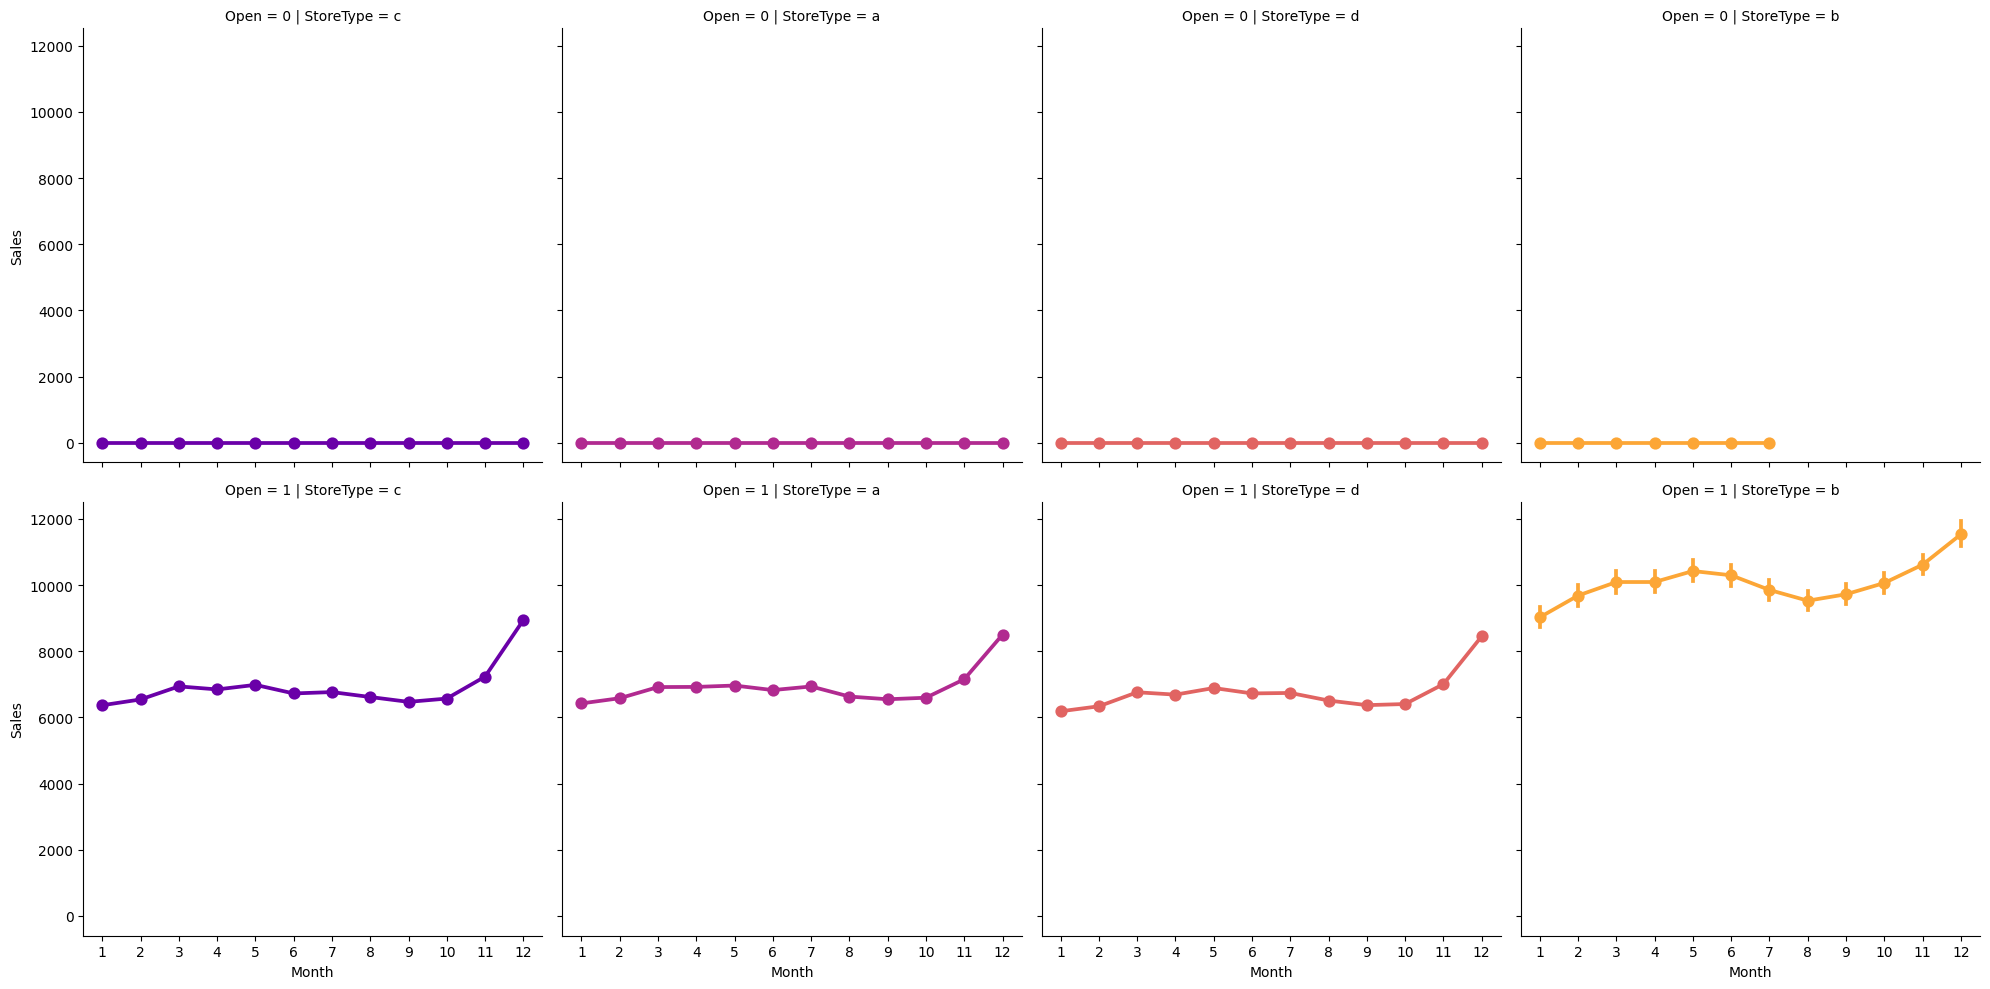

In [39]:

sns.catplot(
    x='Month',
    y='Sales',
    data=Train,
    col='StoreType',
    palette='plasma',
    hue='StoreType',
    row='Open',
kind='point')

In [ ]:
pd.set_option('display.max_rows',24)
Train[['Sales','Open','StoreType']].groupby(['Open','StoreType']).median()

<Axes: xlabel='Sales', ylabel='Count'>

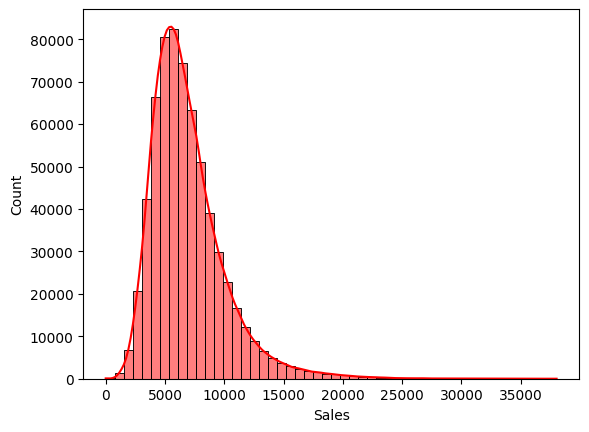

In [13]:
sns.histplot(Train[Train['Open']==1]['Sales'],color='red',kde=True,bins=50)

**Inference :** 
- Sales are zero whenever the store is closed. So Open = 0, (Store Closed) is not providing any significant information.

- It is clear that when Stores are Closed, then they are  not contributing to sales. Also entries did’nt contributes in forecasting. 

- Therefore better to Drop these 130k enteries.


In [16]:
len(Train) # no of observations before

780829

In [32]:
Train = Train[Train['Open']==1]
Test = Test[Test['Open']==1]

In [18]:
len(Train) # no of observations after

648360

In [19]:
780829 -  648360  # how many droped

132469

In [ ]:
# Train[Train['Open']==0].shape

In [20]:

print(Train['Sales'].agg(['skew','kurtosis']))
Train['Sales'].describe()

skew        1.616195
kurtosis    4.944212
Name: Sales, dtype: float64


count    648360.000000
mean       6915.418872
std        3123.958022
min           0.000000
25%        4807.000000
50%        6318.000000
75%        8319.000000
max       38037.000000
Name: Sales, dtype: float64

**Inferences**  -  After removing data of store when it is off(open=0) We got approximately log normal distribution of Sales.
- This States that:
    - Their are very less Sales are of zero on working day.
    - Most of the Sales are near to median(6000).
    - Most of the Sales are less then (8000)
    - Their are few Extreme Sales on +ve side Greater then 8000

# Sales, Promo and StoreType

In [25]:
# sns.barplot(Train['StoreType'],palette='bright')

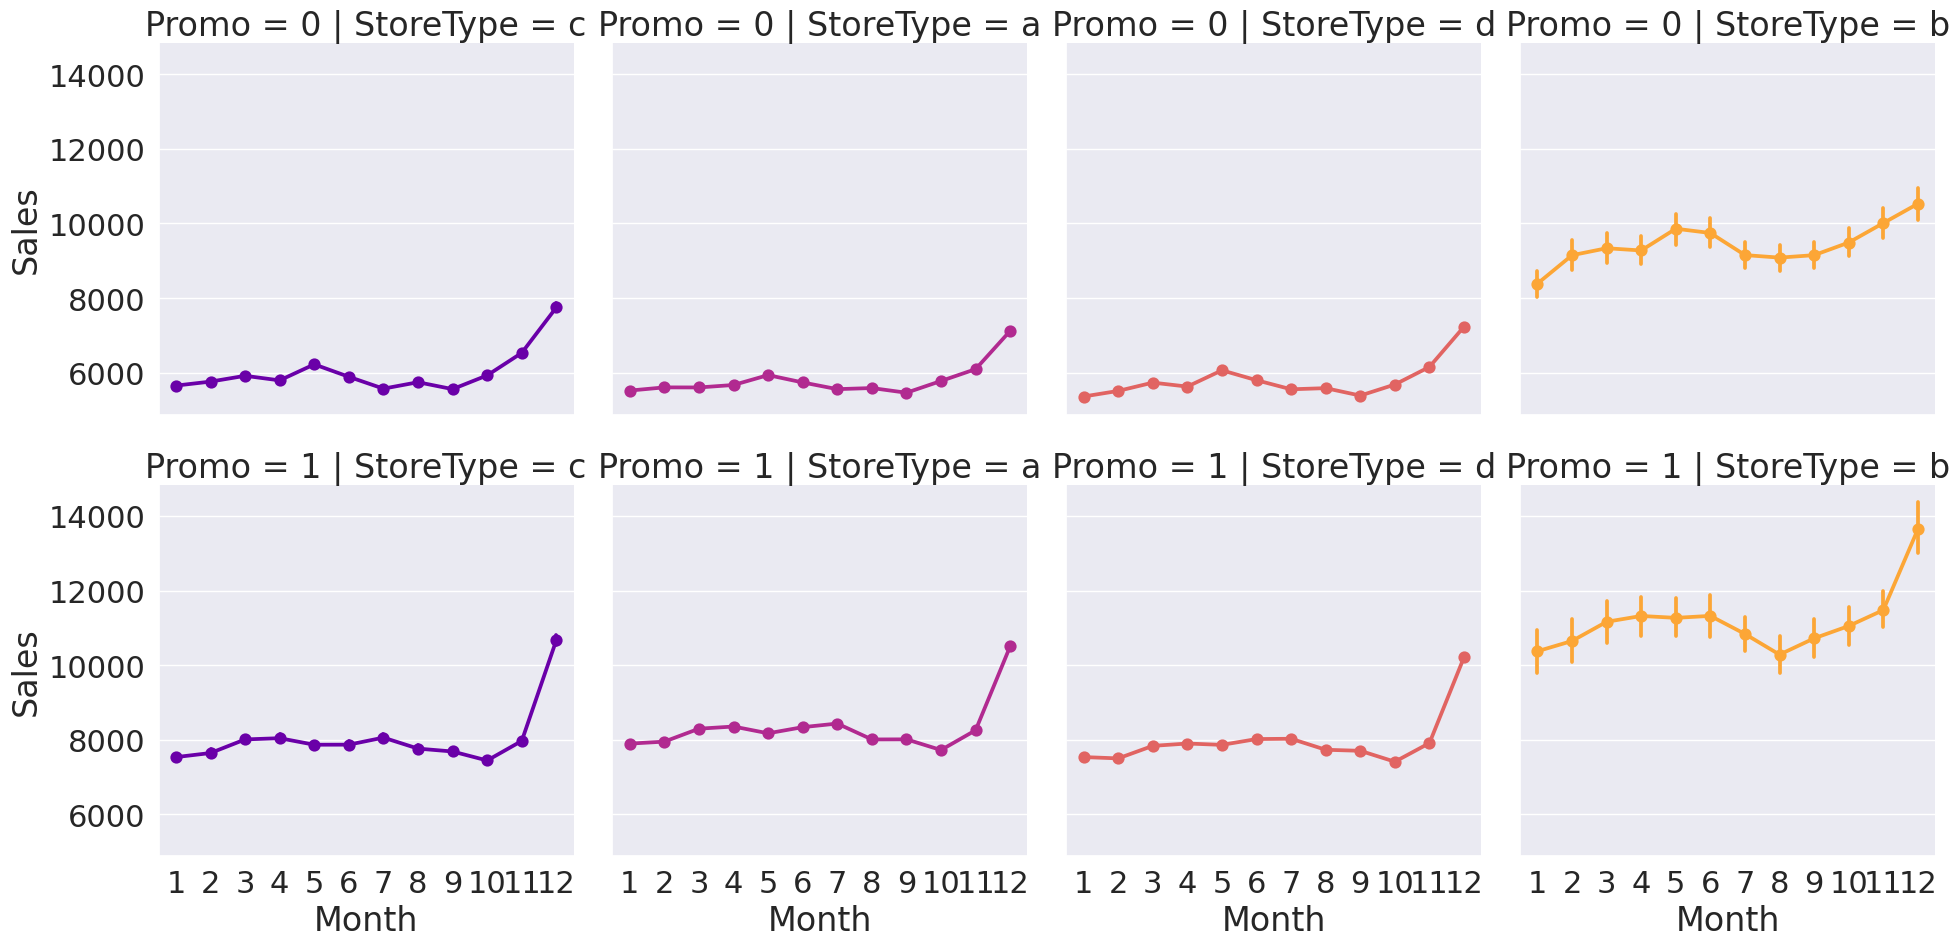

In [26]:
sns.set(font_scale=2)
sns.catplot(
x='Month',
    y='Sales',
    data=Train,
    col='StoreType',
    palette='plasma',
    hue='StoreType',
    row='Promo',
    kind='point')

Sales
Promo StoreType         
0     a           5286.0
      b           8361.5
      c           5495.0
      d           5486.0
1     a           7639.0
      b          10064.0
      c           7523.5
      d           7555.0

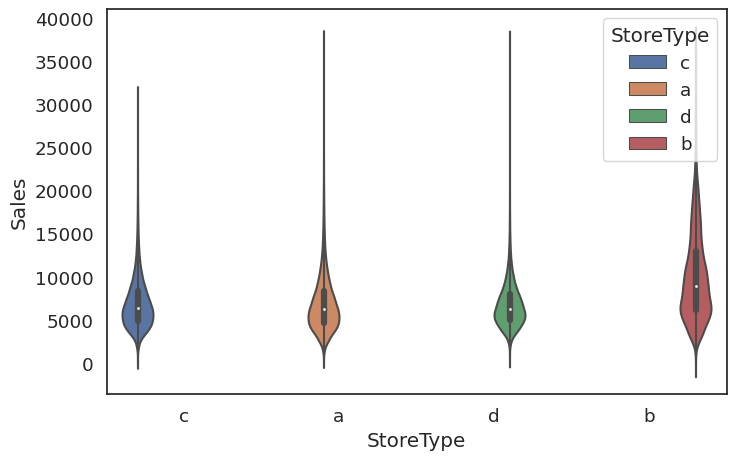

In [35]:
sns.set_theme(font_scale=1.2,style='white')

plt.figure(figsize=(8,5))
sns.violinplot(Train,y='Sales',x='StoreType',hue='StoreType')

pd.set_option('display.max_rows',24)
Train[['Sales','Promo','StoreType']].groupby(['Promo','StoreType']).median()


In [36]:
Promo0 ,Promo1 = (4386 + 4623 + 4761)/3,(7541 + 7437 +	7474)/3
# x * Promo0 = Promo1
X =  Promo1/Promo0
print("Factor by which sales are increased for StoreType a,d,c :",X)
print("Factor by which sales are increased for StoreType     b :",9939/ 8227)



Factor by which sales are increased for StoreType a,d,c : 1.6305010893246188
Factor by which sales are increased for StoreType     b : 1.2080952959766622


**Inference :**
- Sales are Increased by  factor  1.63 approximately for Store type **a,d,c** where store is running promo, But for Store **b** this increase  is of less magnitude(1.2 approx) then other, but in terms of Performance type **b** store performed well with and without promo.
- We can combine These features for better information gain.

In [37]:
for data in [Train,Test]:
    data['NewStoreType'] = data['StoreType'].replace({'a':'a,d,c','d':'a,d,c','c':'a,d,c'})

# CompetitionOpenSinceYear and CompetitionOpenSinceMonth

<Axes: xlabel='CompetitionOpenSinceMonth', ylabel='Sales'>

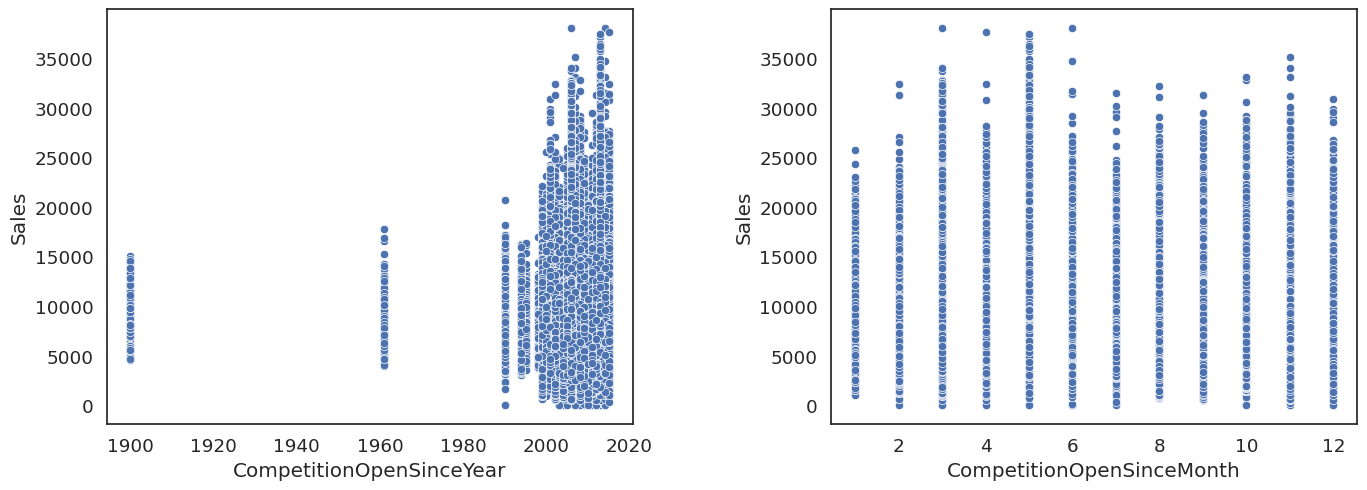

In [38]:
fig, axes = plt.subplots(1,2)
plt.tight_layout()
fig.set_size_inches(15,5)
sns.scatterplot(Train,x='CompetitionOpenSinceYear',y='Sales',ax=axes[0],)
sns.scatterplot(Train,x='CompetitionOpenSinceMonth',y='Sales',ax=axes[1])

**Inferences :**  It seems that alone `CompetitionSinceYear` suggest Most of the competiter are new in market and our client is performing well among them but doesnt in front of old players. also their is no visible trend with `CompetitionSinceMonth`.

In [39]:
for data in [Train,Test]:
    data['CompetitionOpenAge'] = pd.Series(abs((data['Year'] - data['CompetitionOpenSinceYear']) + abs( data['CompetitionOpenSinceMonth'] - data['Month']))/12) # Calculating Age of competition

<Axes: xlabel='CompetitionOpenAge', ylabel='Sales'>

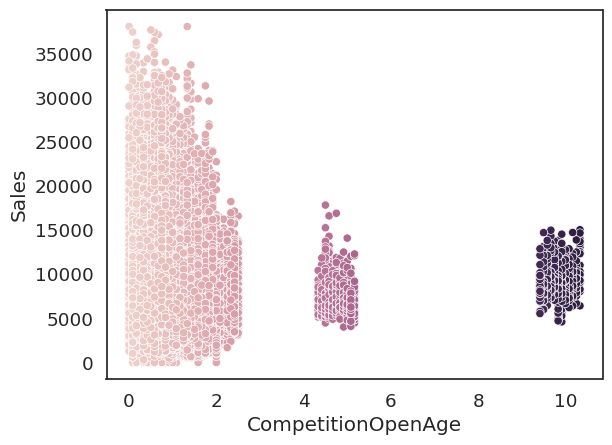

In [40]:
sns.scatterplot(Train, x='CompetitionOpenAge',y='Sales',hue='CompetitionOpenAge',legend=False)

**Inference :**  Most of the competitors are from recent Years, In Term of Sales, Our client is Performing well among all recent players. But still Client have to work more, to perform great against Old players of industaries.

In [41]:
print(f"No. of Not available values are same for Compitition Year and Month {Train['CompetitionOpenSinceMonth'].isna().sum()},{Train['CompetitionOpenSinceYear'].isna().sum()}")

print("Competition Details are Not Recorded and  It indicates no Competition Present in that area") if (len(Train)-(Train['CompetitionOpenSinceMonth'].isna() ==Train['CompetitionOpenSinceYear'].isna()).sum())==0 else print('Compition Details are missing We have to use Imputing Techninques')

No. of Not available values are same for Compitition Year and Month 206344,206344
Competition Details are Not Recorded and  It indicates no Competition Present in that area


In [ ]:
for data in [Train,Test]:
    data['CompetitionOpenAge'].fillna(-1,inplace=True)
    bins = [-float('inf'), 3.5, 7.2, float('inf')]
    binned_data = pd.cut(data['CompetitionOpenAge'], bins,labels=['New','Mid','Exp'])
    pd.set_option('display.max_rows',20)
    data['CompetitionOpenAge'] = binned_data

<Axes: xlabel='CompetitionOpenAge', ylabel='Sales'>

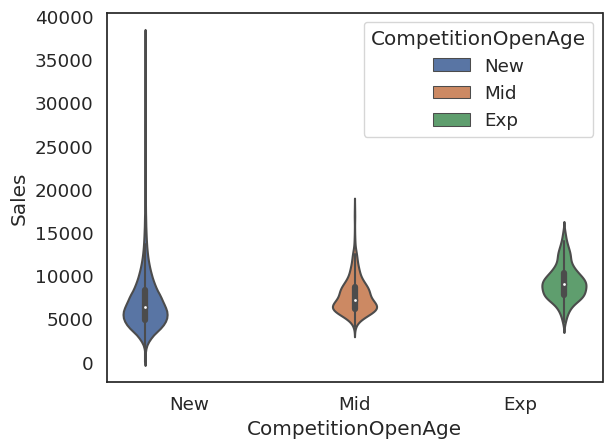

In [45]:
sns.violinplot(Train, x='CompetitionOpenAge',y='Sales',hue='CompetitionOpenAge')

In [46]:
pd.set_option('display.max_rows',100)
Train.isna().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            1660
CompetitionOpenSinceMonth    206344
CompetitionOpenSinceYear     206344
Promo2                            0
Promo2SinceWeek              327231
Promo2SinceYear              327231
PromoInterval                327231
Year                              0
Month                             0
Day                               0
WeekOfYear                        0
NewStoreType                      0
CompetitionOpenAge                0
dtype: int64

## Promo2

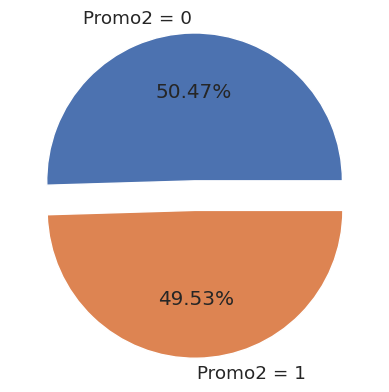

In [47]:
plt.pie(Train['Promo2'].value_counts(),autopct='%.2f%%',explode =(.1,.1),labels=['Promo2 = 0','Promo2 = 1'])
plt.show()

In [48]:
# pd.set_option('display.max_rows',50)
Train[['Promo2','Sales','Year']].groupby(['Promo2','Year']).agg(['mean','median','sum'])

Sales                    
                    mean  median         sum
Promo2 Year                                 
0      2013  7240.798890  6556.0  1197244374
       2014  7389.218743  6724.5  1196196287
1      2013  6405.894169  5911.0  1105631710
       2014  6628.887917  6126.0   984608609

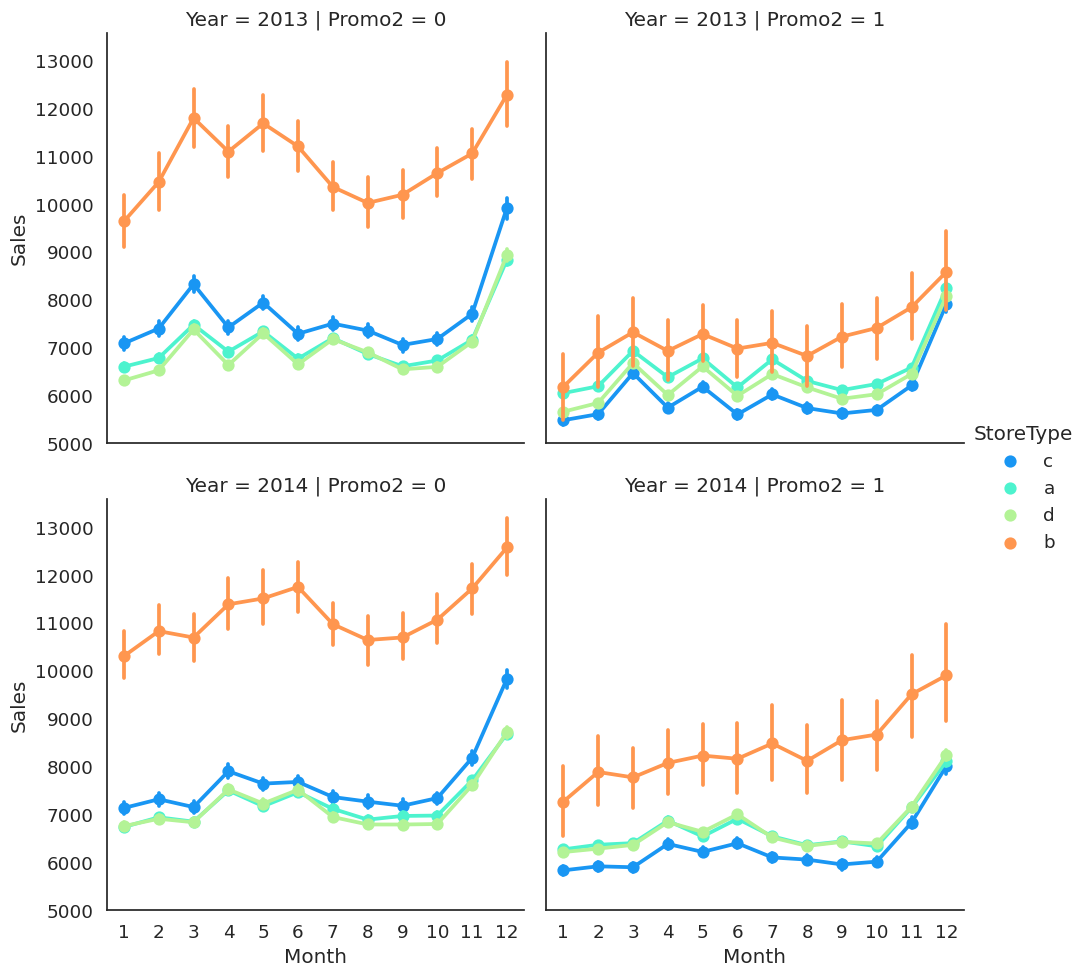

In [50]:
sns.set_theme(font_scale=1.2,style='white')
fig = sns.catplot(
    x='Month',
    y='Sales',
    data=Train,
    col='Promo2',
    palette='rainbow',
    hue='StoreType',
    row='Year',
kind='point')

**Inference :** It seems Participating in Promo2 does not seems to be benificial for Stores. Even Our Best performer Store type **b** also faced downfall in overall sales.

# Promo2SinceYear, Promo2SinceWeek

<Axes: xlabel='Promo2SinceWeek', ylabel='Sales'>

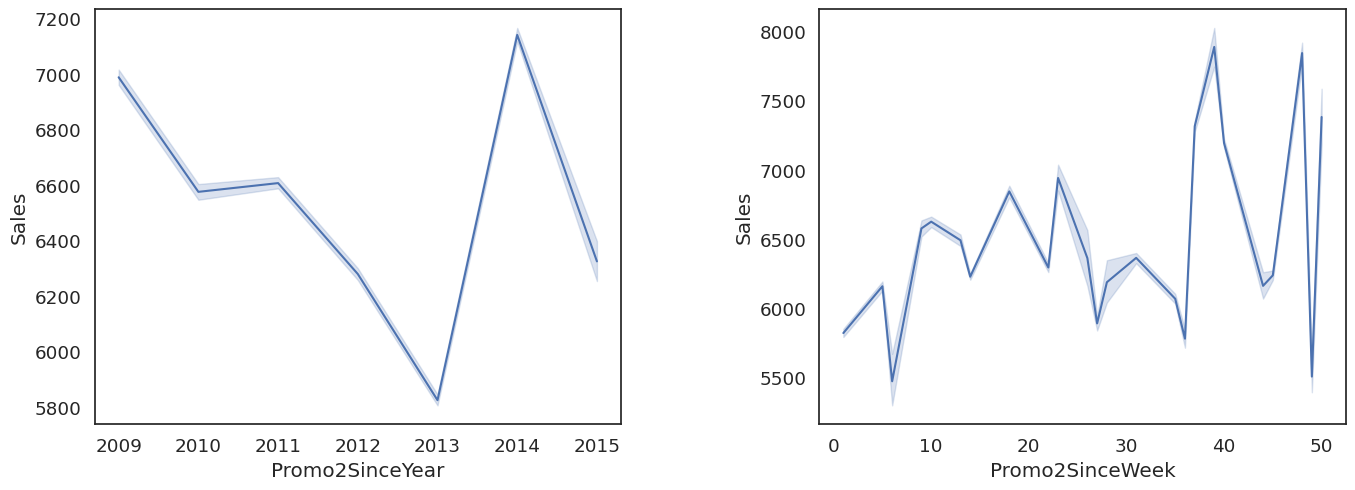

In [51]:
fig, axes = plt.subplots(1,2)
plt.tight_layout()
fig.set_size_inches(15,5)
sns.lineplot(Train,x='Promo2SinceYear',y='Sales',ax=axes[0],)
sns.lineplot(Train,x='Promo2SinceWeek',y='Sales',ax=axes[1])

In [ ]:
# temp = 12 * abs(Train['Year'] -  Train['Promo2SinceYear']) +  abs(Train['WeekOfYear'] - Train['Promo2SinceWeek'])*7/30.5

# sns.kdeplot(temp.fillna(0))
# sns.kdeplot(temp.fillna(-1))
# del(temp)

In [52]:
for data in [Train,Test]:
    temp = 12 * abs(data['Year'] -  data['Promo2SinceYear']) +  abs(data['WeekOfYear'] - data['Promo2SinceWeek'])*7/30.5
    data['Promo2Open_Since'] = temp/12 # years
    del(temp)


In [53]:
Train[['Promo2','Promo2Open_Since',]].groupby('Promo2').mean()

,Promo2Open_Since
Promo2,
0,<NA>
1,2.273321


In [54]:
for data in [Train,Test]:
    data['Promo2Open_Since'] = (data['Promo2Open_Since']).fillna(-1) # -1 indecates no participation in promo2

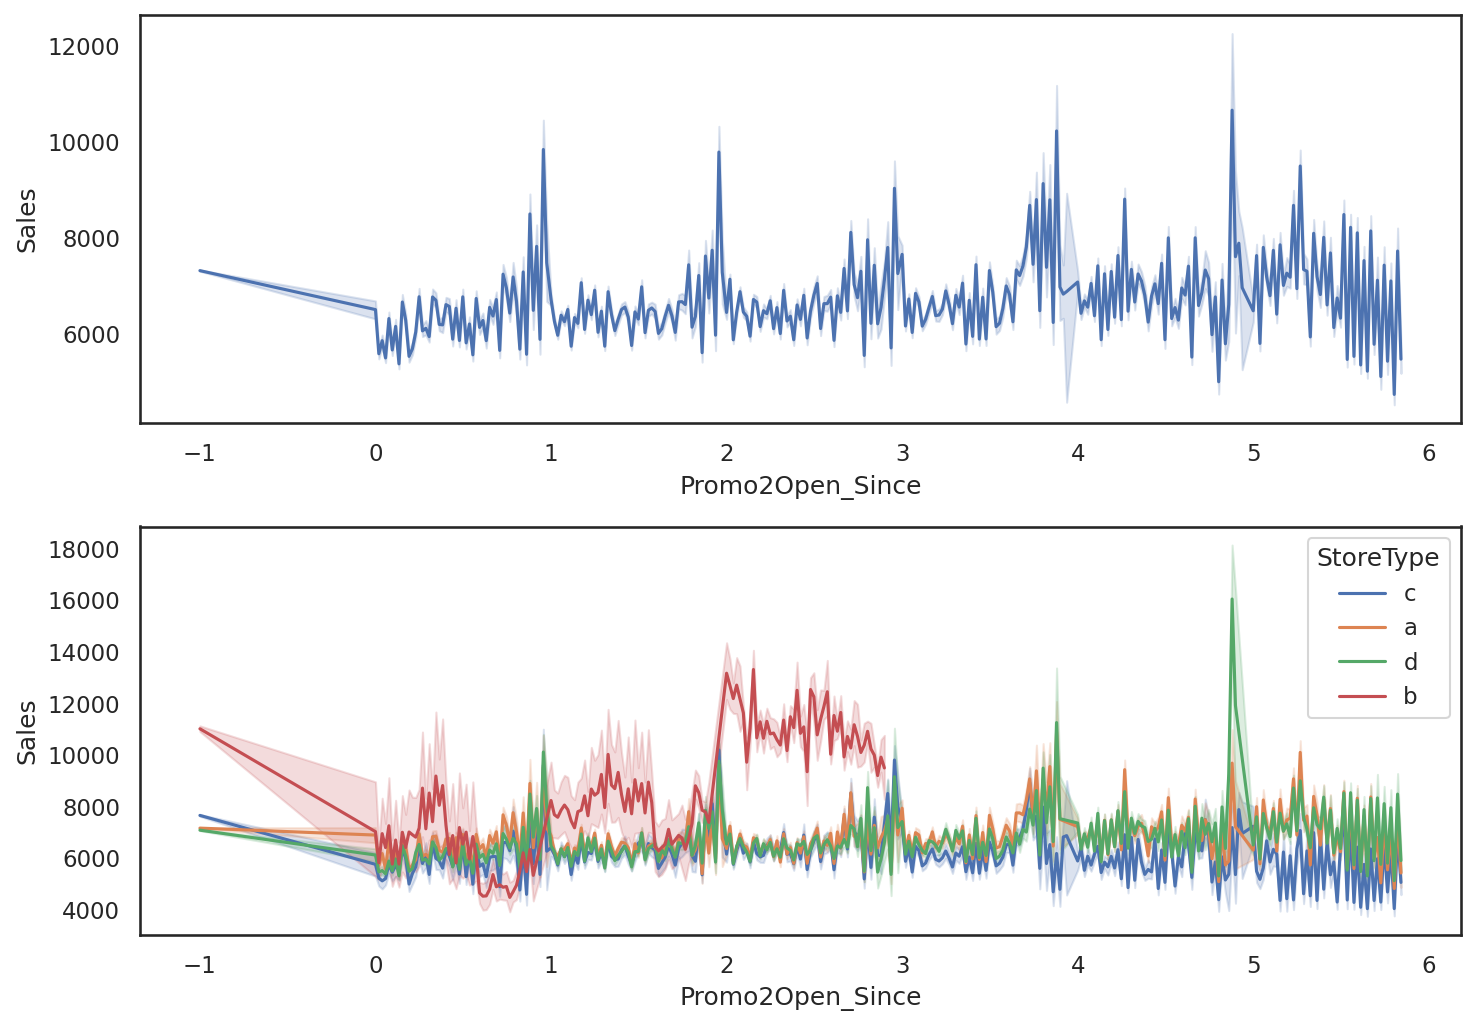

In [55]:
sns.set(style='white')
fig,axes = plt.subplots(2,1,dpi=150)
fig.set_size_inches(10,7)
sns.lineplot(data=Train,
             x='Promo2Open_Since',
             y='Sales',ax=axes[0],estimator='mean')
sns.lineplot(data=Train,
             x='Promo2Open_Since',
             y='Sales',hue='StoreType',ax=axes[1],estimator='mean')
plt.tight_layout()

**Inference :** The Downward drift in sales proved Our Previous claim regarding not better Effect of participating in Promo2.  Store *TypeB* shown unstable increase in sales with lots of Fluctuations .


# Promo Interval


In [56]:
Train['PromoInterval'].value_counts()

PromoInterval
Jan,Apr,Jul,Oct     183752
Feb,May,Aug,Nov      75310
Mar,Jun,Sept,Dec     62067
Name: count, dtype: int64

In [57]:
def check_promo_month(row):
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    try:
        months = (row['PromoInterval'] ).split(',')

        if  month2str[row['Month']] in months:
            return 1
        else:
            return 0
    except :
        return 0

In [58]:
for data in [Train,Test]:
    temp = data.apply(check_promo_month,axis=1)
    data['IsActivePromo2Month'] = temp
    del(temp)

<Axes: xlabel='StoreType', ylabel='Sales'>

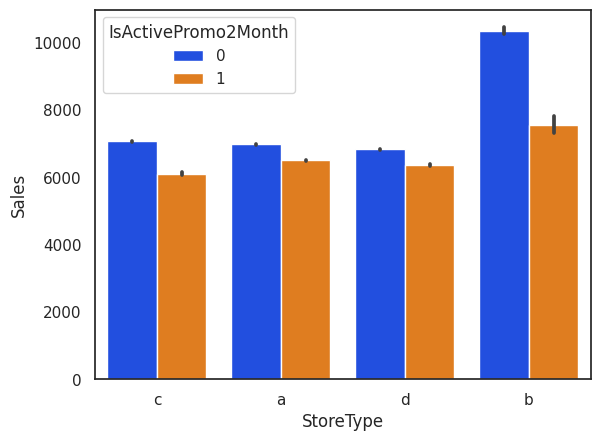

In [59]:
Train['IsActivePromo2Month'].value_counts()

sns.barplot(data=Train,x='StoreType',y='Sales',hue='IsActivePromo2Month',estimator='mean',palette='bright')

In [60]:
Train[['IsActivePromo2Month','Sales','StoreType']].groupby(['IsActivePromo2Month','StoreType']).agg(['mean','sum'])

Sales            
                                       mean         sum
IsActivePromo2Month StoreType                          
0                   a           6981.862838  2072028380
                    b          10355.291906   111816442
                    c           7066.636380   513235667
                    d           6829.829291  1094036205
1                   a           6503.776228   355776071
                    b           7549.766581     8765279
                    c           6109.803681    88292773
                    d           6365.475240   239730163

**Inferences** Here are another proofs against the -ve effect of **Continuing in Promo2**

# Customers

In [61]:
Train['StoreType'].value_counts()

StoreType
a    351476
d    197846
c     87079
b     11959
Name: count, dtype: int64

In [62]:
Train[['Customers','Sales','StoreType']].groupby(['StoreType']).agg(['sum','mean'])

Customers                    Sales              
                 sum         mean         sum          mean
StoreType                                                  
a          281329728   800.423722  2427804451   6907.454424
b           23996425  2006.557823   120581721  10082.926750
c           71389420   819.823608   601528440   6907.847357
d          119777823   605.409374  1333766368   6741.437118

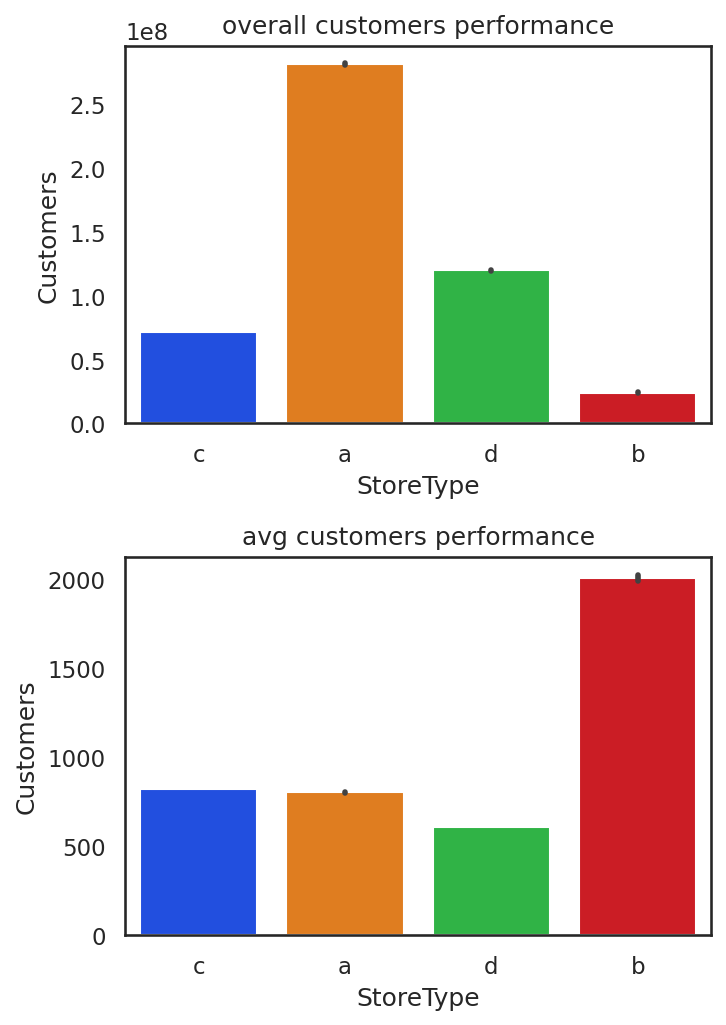

In [63]:
fig,axes = plt.subplots(2,1,dpi=150)
sns.set_style('white')
fig.set_size_inches(5,7)

sns.barplot(Train,y ='Customers',x='StoreType',estimator='sum',ax=axes[0],palette='bright',)
axes[0].set_title('overall customers performance')
sns.barplot(Train,y ='Customers',x='StoreType',estimator='mean',ax=axes[1],palette='bright')
axes[1].set_title('avg customers performance')
plt.tight_layout()

In [66]:
Train[Train['Customers']==0]['Sales']

Series([], Name: Sales, dtype: int64)

**Inferences :** Again In terms of Customers serving performance StoreType **b** has proven good. Also

In [67]:
Train = Train[Train['Customers']>0]
Test = Test[Test['Customers']>0]

In [ ]:
# row = 3

# months = (Train['PromoInterval'][row].split(','))
# # print(months)
# print("Promo2 Interval",months)
# print("Open for Promo2 since months : ",Train.iloc[row]['Promo2Open_Since'])
# print("Current Month",month2str[Train['Month'][row]] )
# print("" ,(month2str[Train['Month'][row]] in months))
# data[data['CompetitionDistance'].isna() ==False]['CompetitionDistance'].sample(len(indexes_of_na))
# dfs

# Competitioin Distance

In [68]:
temp = Train['CompetitionDistance'].copy()



In [69]:
for data in [Train,Test]:
    indexes_of_na = data[data['CompetitionOpenSinceMonth'].isna() & data['CompetitionOpenSinceYear'].isna() & data['CompetitionDistance'].isna()].index
    print(len(indexes_of_na),data['CompetitionDistance'].isna().sum())
    data.loc[indexes_of_na,'CompetitionDistance'] =  list(data[data['CompetitionDistance'].isna() ==False]['CompetitionDistance'].sample(len(indexes_of_na)))
    del(data)
    del(indexes_of_na)




1660 1660
526 526


In [70]:
temp.isna().sum()

1660

<Axes: xlabel='CompetitionDistance', ylabel='Count'>

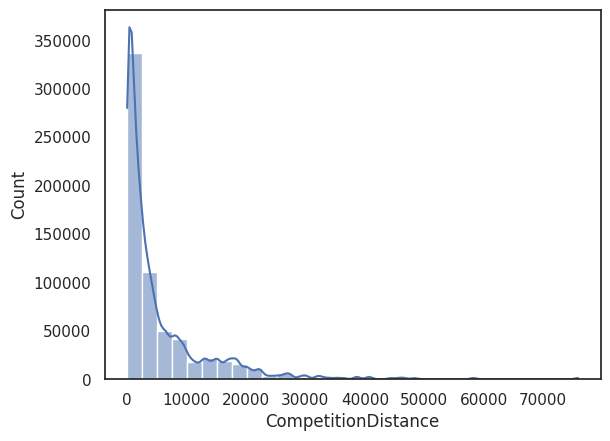

In [71]:
sns.histplot(Train['CompetitionDistance'],kde=True,bins=30)

In [73]:
# (Train['CompetitionDistance']//1000).hist()

In [74]:
for data in [Train,Test]:
    data['CompetitionDistance'].clip(0,10000,inplace=True)

<Axes: xlabel='CompetitionDistance', ylabel='Count'>

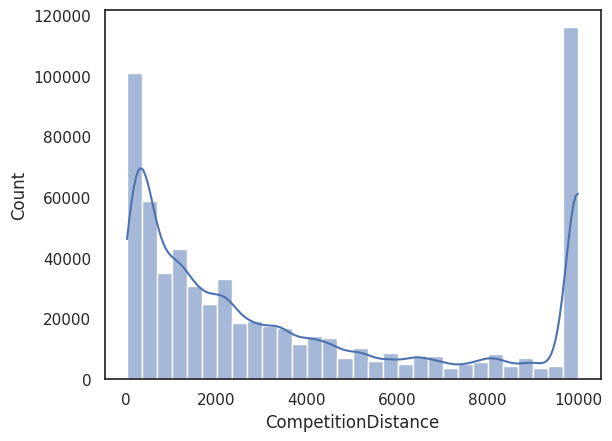

In [76]:
sns.histplot(Train['CompetitionDistance'],kde=True,bins=30)

# Holidays [StateHoliday and SchoolHolidays]

In [77]:
for data in [Train,Test]:
    data['StateHoliday'] = data['StateHoliday'].replace({'0':'NoHoliday','a':'PublicHoliday','b':'EasterHoliday','c':'Christmas',0:'NoHoliday'})

In [78]:
print(Train['SchoolHoliday'].value_counts())
print()
print(Train['StateHoliday'].value_counts())

SchoolHoliday
0    516448
1    131863
Name: count, dtype: int64

StateHoliday
NoHoliday        647643
PublicHoliday       501
EasterHoliday        96
Christmas            71
Name: count, dtype: int64


In [80]:
Train[['StateHoliday','SchoolHoliday','Sales']].groupby(['StateHoliday','SchoolHoliday']).mean()

Sales
StateHoliday  SchoolHoliday              
Christmas     1               9743.746479
EasterHoliday 0              34077.500000
              1               8500.434783
NoHoliday     0               6873.774028
              1               7072.699456
PublicHoliday 0               8255.465394
              1               8268.097561

# Assortment

In [79]:
for data in [Train,Test]:
    data['Assortment'] = data['Assortment'].replace({ 'a': 'basic','b':'extra','c': 'extended'})


In [81]:
Train[['Assortment','Sales']].groupby('Assortment').agg(['mean','count'])

Sales        
                   mean   count
Assortment                     
basic       6612.736116  340938
extended    7229.010101  301071
extra       8362.845763    6302

<Axes: xlabel='Assortment', ylabel='Sales'>

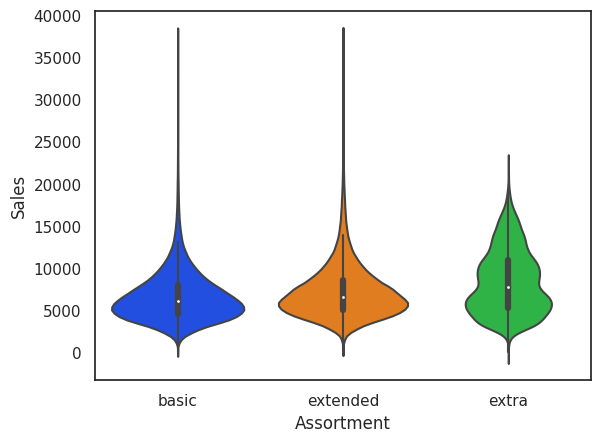

In [84]:
sns.violinplot(data=Train,y='Sales',x='Assortment',gap=.2,palette='bright')

In [85]:
Train["Assortment"].value_counts()

Assortment
basic       340938
extended    301071
extra         6302
Name: count, dtype: int64

In [86]:
pd.set_option('display.max_columns',40)
Train.sample(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,NewStoreType,CompetitionOpenAge,Promo2Open_Since,IsActivePromo2Month
887186,432,6,2013-04-27,7799,1095,1,0,NoHoliday,0,a,basic,810.0,5.0,2013.0,0,NaN,NaN,NaN,2013,4,27,17,"a,d,c",New,-1.0,0
1007737,563,3,2013-01-09,5405,652,1,1,NoHoliday,0,a,basic,700.0,3.0,2015.0,1,10.0,2014.0,"Jan,Apr,Jul,Oct",2013,1,9,2,"a,d,c",New,1.153005,1
879170,221,6,2013-05-04,4924,491,1,0,NoHoliday,0,d,extended,10000.0,9.0,2013.0,0,NaN,NaN,NaN,2013,5,4,18,"a,d,c",New,-1.0,0
986339,350,1,2013-01-28,4474,386,1,0,NoHoliday,0,d,basic,8880.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2013,1,28,5,"a,d,c",New,2.172131,1
571139,1045,3,2014-02-05,6978,821,1,1,NoHoliday,0,a,extended,10000.0,12.0,2013.0,0,NaN,NaN,NaN,2014,2,5,6,"a,d,c",New,-1.0,0


In [87]:
input_features = ['Store', 'DayOfWeek', 'Customers','Promo', 'StateHoliday', 'SchoolHoliday',
                  'Assortment', 'CompetitionDistance','Promo2',
              'Day', 'Month', 'Year', 'WeekOfYear', 'NewStoreType','CompetitionOpenAge',
              'Promo2Open_Since', 'IsActivePromo2Month']

numeric_cols = ['Store','DayOfWeek','Customers' ,'Promo', 'SchoolHoliday',
              'CompetitionDistance','Promo2', 'Day', 'Month', 'Year',
              'WeekOfYear',  'Promo2Open_Since', 'IsActivePromo2Month',
               ]
categorical_cols = ['StateHoliday','NewStoreType']
ordinal_cols = [  'Assortment','CompetitionOpenAge']

target = 'Sales'
print("No. of Input Features",len(input_features))
print("No. of Numerical Input Features",len(numeric_cols))
print("No. of Categorical Input Features",len(categorical_cols))
print("No. of Ordinal Input Features",len(ordinal_cols))

No. of Input Features 17
No. of Numerical Input Features 13
No. of Categorical Input Features 2
No. of Ordinal Input Features 2


In [88]:

X = Train[input_features].copy()
Y = Train[target].copy()
X_Test = Test[input_features].copy()
Y_Test = Test[target].copy()


In [89]:
del(Train)
del(Test)

In [90]:
X.isna().sum()

Store                  0
DayOfWeek              0
Customers              0
Promo                  0
StateHoliday           0
SchoolHoliday          0
Assortment             0
CompetitionDistance    0
Promo2                 0
Day                    0
Month                  0
Year                   0
WeekOfYear             0
NewStoreType           0
CompetitionOpenAge     0
Promo2Open_Since       0
IsActivePromo2Month    0
dtype: int64

In [91]:
X_Test.isna().sum()

Store                  0
DayOfWeek              0
Customers              0
Promo                  0
StateHoliday           0
SchoolHoliday          0
Assortment             0
CompetitionDistance    0
Promo2                 0
Day                    0
Month                  0
Year                   0
WeekOfYear             0
NewStoreType           0
CompetitionOpenAge     0
Promo2Open_Since       0
IsActivePromo2Month    0
dtype: int64

In [92]:
Scaler = StandardScaler().fit(X[numeric_cols])
encoder = OneHotEncoder(sparse_output=False,drop='first').fit(X[categorical_cols])
ordinal = OrdinalEncoder(dtype=np.uint8).fit(X[ordinal_cols])

In [93]:
X[numeric_cols] = Scaler.transform(X[numeric_cols])
X_Test[numeric_cols] = Scaler.transform(X_Test[numeric_cols])

encoded_Features = list(encoder.get_feature_names_out())

X[encoded_Features] = encoder.transform(X[categorical_cols])
X_Test[encoded_Features] = encoder.transform(X_Test[categorical_cols])

ordinal_Features = list(ordinal.get_feature_names_out())

X[ordinal_Features] = ordinal.transform(X[ordinal_cols])
X_Test[ordinal_Features] = ordinal.transform(X_Test[ordinal_cols])

In [94]:
X = X[numeric_cols+encoded_Features+ordinal_Features]
X_Test = X_Test[numeric_cols+encoded_Features +ordinal_Features]

<Axes: >

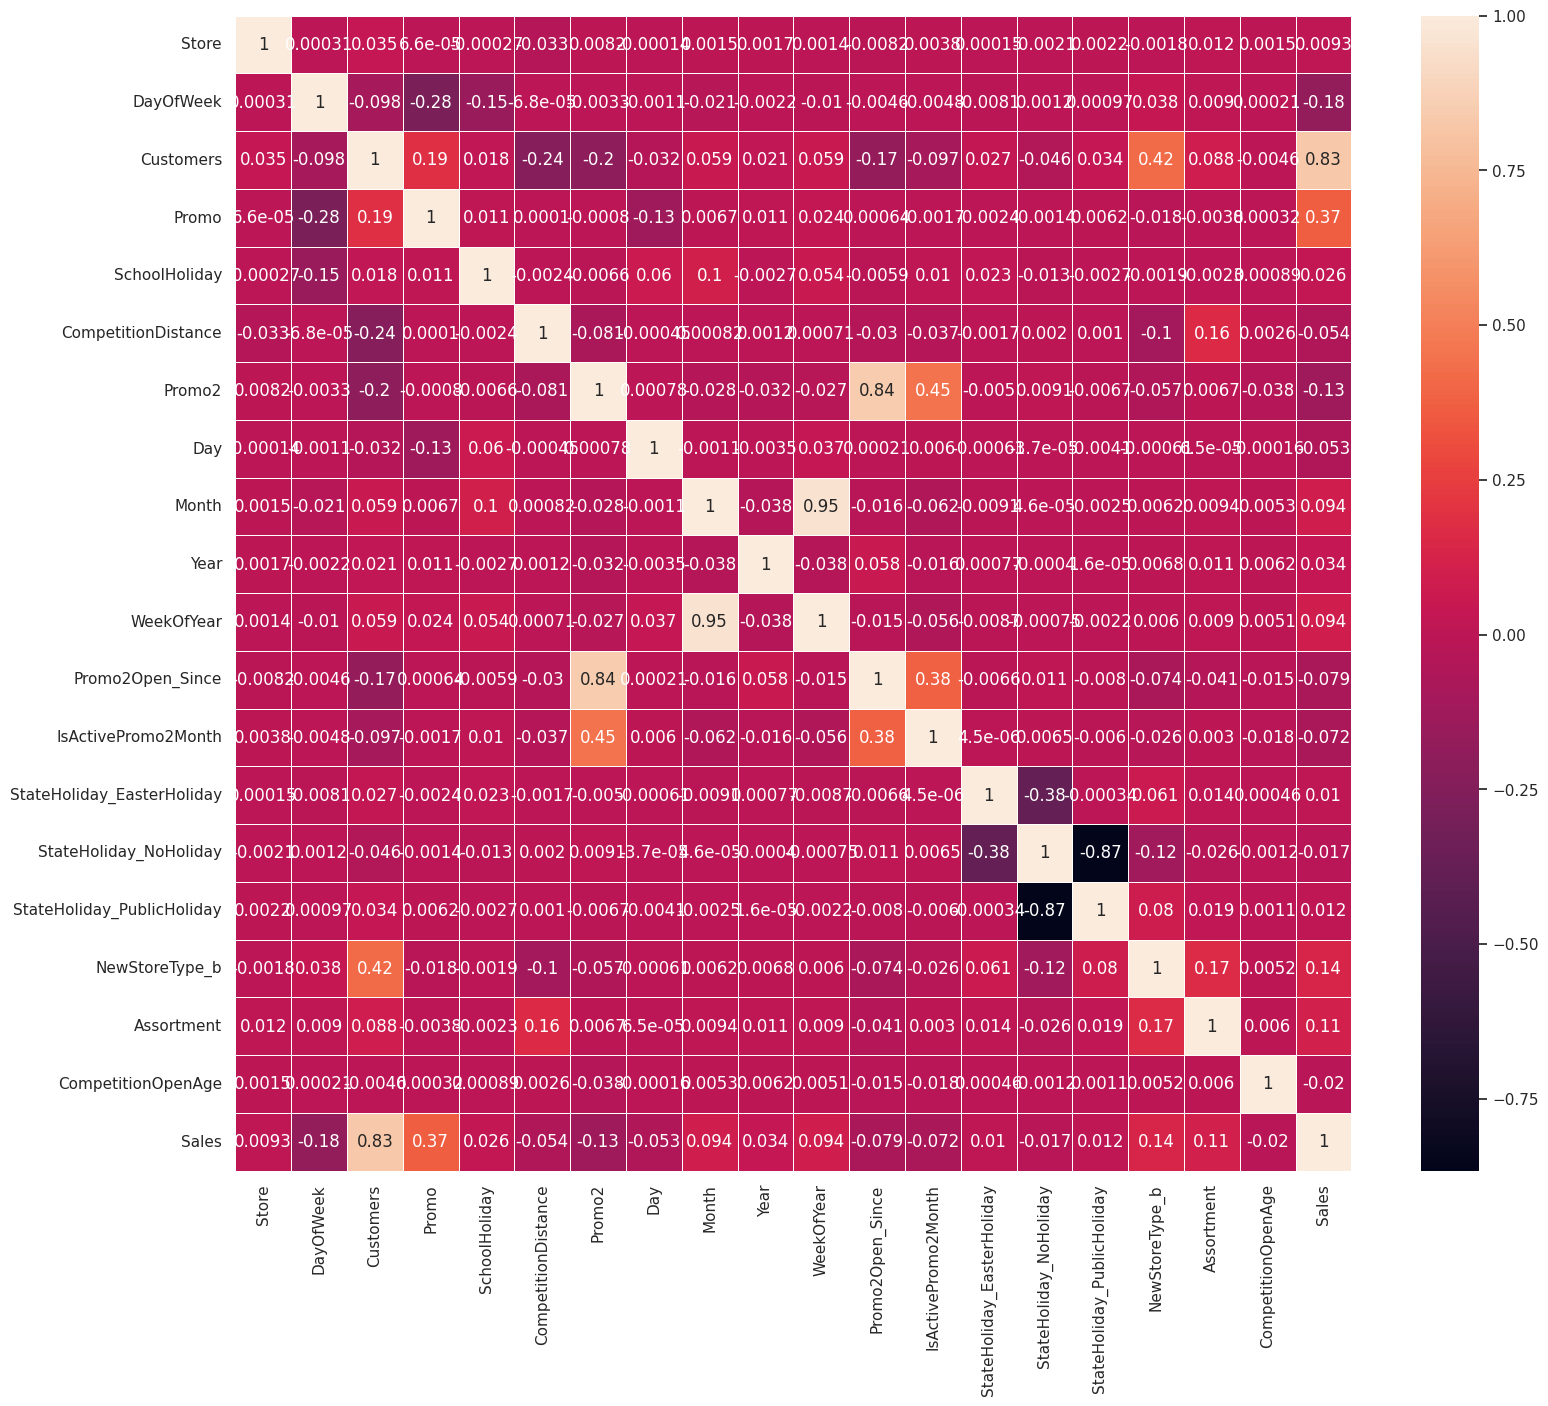

In [95]:
plt.figure(figsize=(18,15))
sns.heatmap(pd.concat((X,Y),axis=1).corr(),annot=True,fmt='.2g',linecolor='white',linewidths=.6)

**Inferences**
- **Customers** and **Promo** are most linearly correlated with Sales.
- Other features shown neutral linear correlation, It might be because these features have non-linear correlation with Sales or No correlation.
- So we are going to use Model with Non linear Hypothesis.

# Memory management and Optimization 

In [96]:
print(f"Size of Training set {(X.memory_usage().sum()/1024**2): .2f} MB ")

Size of Training set  106.39 MB 


In [97]:
def reduce_mem_usage(df,Dense=False, verbose=True):
    
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            if col_type==object:
                df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [98]:
reduce_mem_usage(X)
reduce_mem_usage(X_Test)


Mem. usage decreased to 64.35 Mb (39.5% reduction)
Mem. usage decreased to 18.61 Mb (40.6% reduction)


,Store,DayOfWeek,Customers,Promo,SchoolHoliday,CompetitionDistance,Promo2,Day,Month,Year,WeekOfYear,Promo2Open_Since,IsActivePromo2Month,StateHoliday_EasterHoliday,StateHoliday_NoHoliday,StateHoliday_PublicHoliday,NewStoreType_b,Assortment,CompetitionOpenAge
0,-1.733038,0.859437,-0.520519,1.127654,1.979028,-0.708382,-0.99060,1.751070,0.175238,3.045227,0.340686,-0.836447,-0.446990,0.0,1.0,0.0,0.0,0,2
1,-1.729929,0.859437,-0.347693,1.127654,1.979028,-0.901279,1.00949,1.751070,0.175238,3.045227,0.340686,2.436728,2.237184,0.0,1.0,0.0,0.0,0,2
2,-1.726821,0.859437,0.136222,1.127654,1.979028,1.697329,1.00949,1.751070,0.175238,3.045227,0.340686,1.910934,2.237184,0.0,1.0,0.0,0.0,0,2
3,-1.723713,0.859437,1.807703,1.127654,1.979028,-0.887501,-0.99060,1.751070,0.175238,3.045227,0.340686,-0.836447,-0.446990,0.0,1.0,0.0,0.0,1,2
4,-1.720604,0.859437,-0.510644,1.127654,1.979028,1.697329,-0.99060,1.751070,0.175238,3.045227,0.340686,-0.836447,-0.446990,0.0,1.0,0.0,0.0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235997,0.542293,0.280023,4.284063,-0.886797,1.979028,-0.821365,-0.99060,-1.699835,-1.568720,3.045227,-1.661880,-0.836447,-0.446990,0.0,0.0,1.0,1.0,2,2
236033,0.654194,0.280023,2.271866,-0.886797,1.979028,-0.826876,1.00949,-1.699835,-1.568720,3.045227,-1.661880,1.691031,2.237184,0.0,0.0,1.0,1.0,2,2
236212,1.210593,0.280023,1.081831,-0.886797,1.979028,-0.664291,-0.99060,-1.699835,-1.568720,3.045227,-1.661880,-0.836447,-0.446990,0.0,0.0,1.0,1.0,2,2
236345,1.624007,0.280023,-0.518050,-0.886797,1.979028,-0.948126,-0.99060,-1.699835,-1.568720,3.045227,-1.661880,-0.836447,-0.446990,0.0,0.0,1.0,1.0,0,2


In [ ]:
# from google.colab import drive
# drive.mount('/gdrive')

In [ ]:
# %cd /gdrive

# Exporting Processed Training and Testing set

In [99]:
# os.makedirs('data/Train/X',exist_ok=True)
# os.makedirs('data/Train/Y',exist_ok=True)
# os.makedirs('data/Test/X',exist_ok=True)
# os.makedirs('data/Test/Y',exist_ok=True)

X.to_csv('/kaggle/working/X.csv',index=False)
Y.to_csv('/kaggle/working/Y.csv',index=False)
X_Test.to_csv('/kaggle/working/X_Test.csv',index=False)
Y_Test.to_csv('/kaggle/working/Y_Test.csv',index=False)


# import pandas as pd
# X = pd.read_csv.('/content/drive/MyDrive/PlacementProject/data/Train/X/X.csv')
# Y = pd.read_csv('/content/drive/MyDrive/PlacementProject/data/Train/Y/Y.csv')
# X_Test = pd.read_csv('/content/drive/MyDrive/PlacementProject/data/Test/X/X_Test.csv')
# Y_Test = pd.read_csv('/content/drive/MyDrive/PlacementProject/data/Test/Y/Y_Test.csv')



# Reading Processed Training and Testing set with cudf
-**cudf is much faster then pandas, it helps for faster operations with the help of GPU.**

In [ ]:
import cudf

In [209]:

X = pd.read_csv('/kaggle/working/X.csv')
Y = pd.read_csv('/kaggle/working/Y.csv')
X_Test = pd.read_csv('/kaggle/working/X_Test.csv')
Y_Test = pd.read_csv('/kaggle/working/Y_Test.csv')


# X = cudf.read_csv('/kaggle/working/X.csv')
# Y = cudf.read_csv('/kaggle/working/Y.csv')
# X_Test = cudf.read_csv('/kaggle/working/X_Test.csv')
# Y_Test = cudf.read_csv('/kaggle/working/Y_Test.csv')

# XGBRegressor 

### Why eXtreame Gradient Boosting Regressor ?
- It support and utilize GPU Operations for Training the model. As we have large dataset as well as **GPU** support XGboost is best option.

In [102]:
# import xgboost
# from xgboost import XGBRegressor

In [103]:
xgboost.__version__ # '2.0.3'

'2.0.3'

In [93]:
import tensorflow as tf

2024-06-15 12:08:07.049666: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-15 12:08:07.049773: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-15 12:08:07.180965: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [97]:
tf.test.is_gpu_available() # True if gpu avaliable

True

In [126]:
# os.environ["NUMBA_ENABLE_CUDASIM"] = "1"
# os.environ["NUMBA_CUDA_DEBUGINFO"] = "1"

In [242]:
random_state=42

In [243]:
initial_model = XGBRegressor(device='gpu',verbosity=0,random_state=42)

### Training model

In [244]:
%%time 
initial_model.fit(X,Y)

CPU times: user 2.68 s, sys: 50.8 ms, total: 2.73 s
Wall time: 1.21 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [245]:
Y_array = Y.to_numpy()
Y_Test_array  = Y_Test.to_numpy()


### Evaluating

In [246]:
print('Training error :',root_mean_square_error(Y_array,initial_model.predict(X)))
print('Testing error :',root_mean_square_error(Y_Test_array,initial_model.predict(X_Test)))

Training error : 611.3542139522323
Testing error : 752.3051152324464


In [119]:
import sklearn
sklearn.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

In [120]:
scores = cross_val_score(estimator=initial_model,X=X.to_numpy(),y=Y.to_numpy(),cv=5,scoring='neg_root_mean_squared_error',error_score="raise")


In [123]:
print(abs(scores))
print(abs(scores.mean()))

[699.32140554 676.11941131 698.80835709 674.59050832 645.36776879]
678.8414902126506


#### Now our task is to reduce this error

## Feature Importance

In [124]:
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': initial_model.feature_importances_
}).sort_values('Importance', ascending=False)

In [126]:
importance_df

,Feature,Importance
2,Customers,0.387218
16,NewStoreType_b,0.202819
3,Promo,0.086197
17,Assortment,0.083910
5,CompetitionDistance,0.038661
18,CompetitionOpenAge,0.030830
6,Promo2,0.027636
1,DayOfWeek,0.023401
11,Promo2Open_Since,0.022793
10,WeekOfYear,0.021748


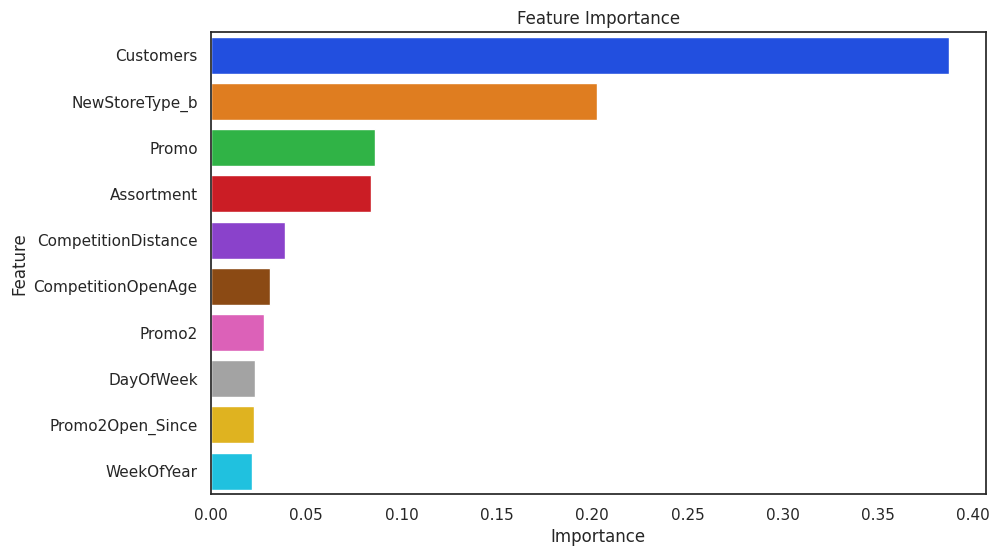

In [128]:
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='Importance', y='Feature',palette='bright');

In [131]:
xgb= XGBRegressor(device='gpu',n_jobs=-1, random_state=42, n_estimators=100,
                     learning_rate=0.2, max_depth=12, tree_method='gpu_hist' )


In [178]:
params = {'n_estimators':[50,70,90,110],
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 5, 7, 10],
        'learning_rate': [0.01, 0.02, 0.05]    
        }

# HyperParameter tunning

In [247]:
# %%time
xgb = XGBRegressor(device='gpu',random_state=42)

random_search = RandomizedSearchCV(xgb, param_distributions=params, scoring= 'neg_root_mean_squared_error', cv=5, verbose=3, random_state=1001 )

In [147]:
import torch

In [153]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [162]:
X = torch.tensor(X.to_numpy())
Y = torch.tensor(Y.to_numpy())

In [248]:
%%time
random_search.fit(X,Y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.05, max_depth=7, min_child_weight=1, n_estimators=50, subsample=0.8;, score=-1157.797 total time=   0.9s
[CV 2/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.05, max_depth=7, min_child_weight=1, n_estimators=50, subsample=0.8;, score=-1175.341 total time=   0.9s
[CV 3/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.05, max_depth=7, min_child_weight=1, n_estimators=50, subsample=0.8;, score=-1210.829 total time=   1.0s
[CV 4/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.05, max_depth=7, min_child_weight=1, n_estimators=50, subsample=0.8;, score=-1113.017 total time=   0.9s
[CV 5/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.05, max_depth=7, min_child_weight=1, n_estimators=50, subsample=0.8;, score=-1088.330 total time=   0.9s
[CV 1/5] END colsample_bytree=1.0, gamma=1.5, learning_rate=0.01, max_depth=10, min_child_weight=5, n_estimators=7

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device='gpu',
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate...
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=42, ...),
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                        'learning_rate': [0.01, 0.02, 0.05],
                                        'max_depth': [3, 5, 7, 10],
                                        'min_child_weight': [1, 5, 10],
                                        'n_estimators': [50, 70, 90, 110],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=1001, scoring='neg_root_mean_squared_error',
                   verbose=3)

In [251]:
print('BestScore',abs(random_search.best_score_))

BestScore 810.5711170248287


### Best Parameters after lot of experiments

In [252]:
random_search.best_params_

{'subsample': 0.8,
 'n_estimators': 110,
 'min_child_weight': 10,
 'max_depth': 10,
 'learning_rate': 0.05,
 'gamma': 1.5,
 'colsample_bytree': 0.6}

In [253]:
final = XGBRegressor(device='gpu',random_state=42,**random_search.best_params_)

In [255]:
final.fit(X,Y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1.5, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=110, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [256]:
from sklearn.model_selection import cross_val_score
scores =cross_val_score(estimator=final,X=X,y=Y,scoring='neg_root_mean_squared_error')

In [262]:
print(scores)
print("Final Cross validation Score",scores.mean())

[-826.57053723 -817.28417781 -853.62149768 -789.22403777 -766.15533463]
Final Cross validation Score -810.5711170248287


In [259]:
print('Training error :',root_mean_square_error(Y_array,final.predict(X)))
print('Testing error :',root_mean_square_error(Y_Test_array,final.predict(X_Test)))

Training error : 726.6664135718868
Testing error : 886.5392200314195


##### Saving model in bytestream file fromat

In [260]:
joblib.dump(final,'/kaggle/working/model.pkl')

['/kaggle/working/model.pkl']

## Conclusion

In conclusion, our comprehensive analysis and forecasting model have provided significant insights into the sales patterns of XYZ Drug Stores. By utilizing a combination of historical sales data and advanced machine learning techniques, we were able to accurately predict future sales trends. Key findings include:

1. **Sales Influencers**: Promotions, competition, holidays, and store characteristics significantly impact sales. First Promotional activitie generally boosted sales, but the effect varies across different store types.
2. **Data Quality**: Cleaning the dataset by removing entries with zero sales due to store closures or holidays improved the accuracy of our model.
3. **Model Selection**: Given large dataset and non-linear nature of the data, XGBoost Regressor was chosen for its efficiency in handling large datasets and its capability to leverage GPU support.
4. **Feature Importance**: Features such as customer count and promotional activities were found to be highly correlated with sales, while others showed non-linear relationships.
5. **Performance**: The final model achieved a training rmse of 726.666 and a testing rmse of 886.539, demonstrating robust predictive performance.




In [234]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras import Input
# model = Sequential()
# model.add(Input(shape=(X.shape[1],)))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(64, activation='tanh'))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(8, activation='relu'))
# model.add(Dense(1))

In [235]:
# model.compile(optimizer='adam',
#              loss = 'mean_squared_error',
#          metrics=['root_mean_squared_error'],
              
#              )

In [237]:
# model.fit(X,Y,
#          epochs=10,
#          batch_size=64,
#          validation_data=(X_Test,Y_Test),
        
#      )